In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import MobileNetV2

In [22]:
train_dir = "Data/train_data"
valid_dir = "Data/valid_data"

img_width, img_height = 224, 224

In [23]:
conv_base = MobileNetV2(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [24]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1280))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,6))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 9000)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 360)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 9000 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


In [25]:
train_labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [42]:
epochs = 15

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,1280)))
model.add(Dense(1280, activation="relu"))
model.add(Dense(640, activation="relu"))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1280)              1639680   
_________________________________________________________________
dense_18 (Dense)             (None, 640)               819840    
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 3846      
Total params: 2,463,366
Trainable params: 2,463,366
Non-trainable params: 0
_________________________________________________________________


In [43]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/15
278/282 [============================>.] - ETA: 0s - loss: 0.8751 - acc: 0.6237
Epoch 00001: val_loss improved from inf to 0.75463, saving model to model-001-0.624000-0.697222.h5
282/282 [==============================] - 4s 16ms/step - loss: 0.8736 - acc: 0.6240 - val_loss: 0.7546 - val_acc: 0.6972
Epoch 2/15
280/282 [============================>.] - ETA: 0s - loss: 0.6835 - acc: 0.6941
Epoch 00002: val_loss improved from 0.75463 to 0.64594, saving model to model-002-0.694333-0.708333.h5
282/282 [==============================] - 3s 11ms/step - loss: 0.6836 - acc: 0.6943 - val_loss: 0.6459 - val_acc: 0.7083
Epoch 3/15
278/282 [============================>.] - ETA: 0s - loss: 0.6448 - acc: 0.7147
Epoch 00003: val_loss did not improve from 0.64594
282/282 [==============================] - 3s 11ms/step - loss: 0.6451 - acc: 0.7148 - val_loss: 0.6483 - val_acc: 0.7111
Epoch 4/15
280/282 [============================>.] - ETA: 0s - loss: 0.6069 - acc: 0.7300
Epoch 00004: val_

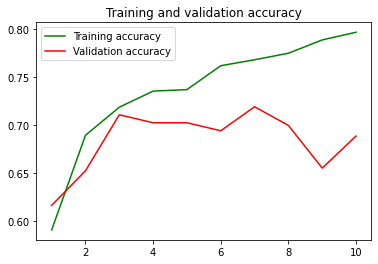

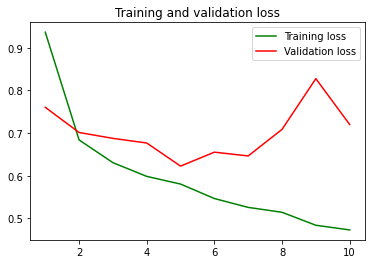

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = ["1", "2", "3", "4", "5", "6"]
    print("I see..."+str(classes[np.argmax(np.array(prediction[0]))]))

In [19]:
pred_dir = "Data/test_data"
import random
pred_files = random.sample(os.listdir(pred_dir),10)
for f in pred_files:
    prediction(pred_dir+f)

NameError: name 'image' is not defined

In [20]:
conv_base2 = MobileNetV2(weights='imagenet',
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________